In [1]:
import numpy as np
import os
import math
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

## import seq-borg results

In [2]:
# import results
city = 'Rotterdam'  # ['Rotterdam', 'DenHelder']:
vary_param = 'nodes'  # ['nodes', 'units']:
algorithm = 'seq_borg_citygraphs'
# algorithm = 'pydsol_borg_citygraphs'
results_seq_borg = pd.read_csv(f'cleaned_data/{algorithm}/df_{city}_{vary_param}_cleaned.csv')

del results_seq_borg['Unnamed: 0']
# results_Rotterdam_nodes = pd.read_csv('cleaned_data/df_Rotterdam_nodes_cleaned.csv')
# results_Rotterdam_units = pd.read_csv('cleaned_data/df_Rotterdam_units_cleaned.csv')
#
# results_DenHelder_nodes = pd.read_csv('cleaned_data/df_Den Helder_nodes_cleaned.csv')
# results_DenHelder_units = pd.read_csv('cleaned_data/df_Den Helder_units_cleaned.csv')

In [3]:
results_seq_borg

,nfe,best_score,elapsed_time,pi_0,pi_1,pi_2,pi_3,pi_4,probability_SBX,probability_PCX,...,probability_UNDX,probability_SPX,probability_UM,number_of_nodes,number_of_units,config,seed,improvement,elapsed time (min),scaled score
0,241,0.804,0.498288,13.0,3.0,32.0,2.0,15.0,0.161905,0.161905,...,0.238095,0.123810,0.161905,140,5,0,0,0.044,0.008305,0.807229
1,387,0.878,0.659430,2.0,47.0,2.0,42.0,13.0,0.266667,0.228571,...,0.171429,0.038095,0.152381,140,5,0,0,0.074,0.010990,0.881526
2,533,0.984,0.826881,17.0,15.0,2.0,13.0,34.0,0.342857,0.266667,...,0.123810,0.019048,0.104762,140,5,0,0,0.106,0.013781,0.987952
3,2750,0.996,2.840034,17.0,17.0,2.0,13.0,6.0,0.698113,0.103774,...,0.009434,0.009434,0.028302,140,5,0,0,0.012,0.047334,1.000000
4,100,0.760,0.358079,2.0,47.0,4.0,17.0,13.0,0.166667,0.166667,...,0.166667,0.166667,0.166667,140,5,0,0,0.000,0.005968,0.763052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7428,17458,0.818,16.375831,29.0,16.0,154.0,5.0,170.0,0.952830,0.009434,...,0.009434,0.009434,0.009434,2514,5,9,4,0.002,0.272931,0.976134
7429,20139,0.822,18.790563,0.0,16.0,154.0,5.0,187.0,0.943396,0.009434,...,0.009434,0.009434,0.018868,2514,5,9,4,0.004,0.313176,0.980907
7430,20285,0.828,18.927179,29.0,16.0,154.0,5.0,279.0,0.943396,0.009434,...,0.009434,0.009434,0.018868,2514,5,9,4,0.006,0.315453,0.988067
7431,20881,0.838,19.454052,29.0,16.0,154.0,5.0,187.0,0.933962,0.009434,...,0.009434,0.009434,0.028302,2514,5,9,4,0.010,0.324234,1.000000


In [4]:
for num_nodes in results_seq_borg[f'number_of_{vary_param}'].unique():
    print(num_nodes)

140
256
530
689
957
1208
1541
1872
2264
2514


In [5]:
# # scale score to optimum found with MIP solver
# scaled_result_list = []
# for index, row in results_df.iterrows():
#     score_MIP_at_row = best_solutions_ROT_nodes[row[f'number_of_{vary_param}']][row['config']]
#     scaled_score = row['best_score'] / score_MIP_at_row
#     scaled_result_list.append(scaled_score)
#
# results_df['scaled score'] = scaled_result_list
# results_df

In [6]:
time_of_90_seq_borg = pd.DataFrame(columns=["number_of_nodes", "time_of_90", "nfe_of_90", "config", "seed"])
time_of_95_seq_borg = pd.DataFrame(columns=["number_of_nodes", "time_of_95", "nfe_of_95", "config", "seed"])

for num_nodes in results_seq_borg['number_of_nodes'].unique():
    for seed in results_seq_borg['seed'].unique():
        for config in results_seq_borg['config'].unique():
            results_subset = results_seq_borg.query(f"config == {config} & seed == {seed} & number_of_nodes == {num_nodes}")

            row_of_first_90 = results_subset[results_subset['scaled score'].ge(0.9)].drop_duplicates(subset='seed', keep='first')
            row_of_first_95 = results_subset[results_subset['scaled score'].ge(0.95)].drop_duplicates(subset='seed', keep='first')
            time_of_90_seq_borg = pd.concat([time_of_90_seq_borg, row_of_first_90], ignore_index=True)
            time_of_95_seq_borg = pd.concat([time_of_95_seq_borg, row_of_first_95], ignore_index=True)

time_of_90_seq_borg['nfe_of_90'] = time_of_90_seq_borg['nfe']
time_of_90_seq_borg['time_of_90'] = time_of_90_seq_borg['elapsed_time']
time_of_95_seq_borg['nfe_of_95'] = time_of_95_seq_borg['nfe']
time_of_95_seq_borg['time_of_95'] = time_of_95_seq_borg['elapsed_time']

time_of_90_seq_borg=time_of_90_seq_borg.drop(['elapsed_time', 'nfe', 'best_score', 'scaled score', 'improvement'], axis=1)
time_of_95_seq_borg=time_of_95_seq_borg.drop(['elapsed_time', 'nfe', 'best_score', 'scaled score', 'improvement'], axis=1)

time_of_90_seq_borg.insert(1, 'algorithm', 'sequential simulation-optimization, metaheuristic')
time_of_95_seq_borg.insert(1, 'algorithm', 'sequential simulation-optimization, metaheuristic')

time_of_95_seq_borg

,number_of_nodes,algorithm,time_of_95,nfe_of_95,config,seed,pi_0,pi_1,pi_2,pi_3,pi_4,probability_SBX,probability_PCX,probability_DE,probability_UNDX,probability_SPX,probability_UM,number_of_units,elapsed time (min)
0,140,"sequential simulation-optimization, metaheuristic",0.826881,533.0,0,0,17.0,15.0,2.0,13.0,34.0,0.342857,0.266667,0.142857,0.123810,0.019048,0.104762,5.0,0.013781
1,140,"sequential simulation-optimization, metaheuristic",1.002710,827.0,2,0,2.0,1.0,13.0,41.0,47.0,0.424528,0.358491,0.075472,0.066038,0.009434,0.066038,5.0,0.016712
2,140,"sequential simulation-optimization, metaheuristic",1.425807,1568.0,3,0,13.0,0.0,15.0,5.0,26.0,0.792453,0.103774,0.028302,0.009434,0.009434,0.056604,5.0,0.023763
3,140,"sequential simulation-optimization, metaheuristic",0.762000,671.0,4,0,15.0,42.0,4.0,13.0,3.0,0.421569,0.245098,0.088235,0.078431,0.009804,0.156863,5.0,0.012700
4,140,"sequential simulation-optimization, metaheuristic",0.231478,100.0,5,0,0.0,3.0,0.0,0.0,1.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,5.0,0.003858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,2514,"sequential simulation-optimization, metaheuristic",5.145105,4379.0,5,4,14.0,393.0,62.0,357.0,44.0,0.952830,0.009434,0.009434,0.009434,0.009434,0.009434,5.0,0.085752
475,2514,"sequential simulation-optimization, metaheuristic",2.066436,1845.0,6,4,51.0,34.0,5.0,4.0,45.0,0.801887,0.047170,0.084906,0.009434,0.009434,0.047170,5.0,0.034441
476,2514,"sequential simulation-optimization, metaheuristic",5.336886,5616.0,7,4,41.0,29.0,26.0,10.0,5.0,0.952830,0.009434,0.009434,0.009434,0.009434,0.009434,5.0,0.088948
477,2514,"sequential simulation-optimization, metaheuristic",5.033913,5130.0,8,4,160.0,280.0,14.0,39.0,10.0,0.952830,0.009434,0.009434,0.009434,0.009434,0.009434,5.0,0.083899


## import pydsol-borg results

In [7]:
# import results
city = 'Rotterdam'  # ['Rotterdam', 'DenHelder']:
vary_param = 'nodes'  # ['nodes', 'units']:
algorithm = 'pydsol_borg_citygraphs'
results_pydsol_borg = pd.read_csv(f'cleaned_data/{algorithm}/df_{city}_{vary_param}_cleaned.csv')

del results_pydsol_borg['Unnamed: 0']
# results_Rotterdam_nodes = pd.read_csv('cleaned_data/df_Rotterdam_nodes_cleaned.csv')
# results_Rotterdam_units = pd.read_csv('cleaned_data/df_Rotterdam_units_cleaned.csv')
#
# results_DenHelder_nodes = pd.read_csv('cleaned_data/df_Den Helder_nodes_cleaned.csv')
# results_DenHelder_units = pd.read_csv('cleaned_data/df_Den Helder_units_cleaned.csv')

In [8]:
results_pydsol_borg

,nfe,best_score,elapsed_time,pi_0,pi_1,pi_2,pi_3,pi_4,probability_SBX,probability_PCX,...,probability_UNDX,probability_SPX,probability_UM,number_of_nodes,number_of_units,config,seed,improvement,elapsed time (min),scaled score
0,242,0.820,2.439705,28.0,26.0,12.0,1.0,15.0,0.314286,0.114286,...,0.209524,0.104762,0.114286,140,5,0,0,0.012,0.040662,0.820000
1,390,0.852,3.674273,27.0,46.0,2.0,33.0,16.0,0.361905,0.161905,...,0.190476,0.047619,0.085714,140,5,0,0,0.032,0.061238,0.852000
2,536,0.942,4.903454,27.0,46.0,2.0,21.0,17.0,0.409524,0.238095,...,0.104762,0.047619,0.095238,140,5,0,0,0.090,0.081724,0.942000
3,978,0.986,8.852270,13.0,46.0,2.0,1.0,20.0,0.688679,0.075472,...,0.056604,0.028302,0.075472,140,5,0,0,0.044,0.147538,0.986000
4,1721,0.990,15.301868,27.0,13.0,2.0,1.0,20.0,0.886792,0.047170,...,0.009434,0.018868,0.018868,140,5,0,0,0.004,0.255031,0.990000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7564,8846,0.782,311.887745,4.0,16.0,5.0,187.0,29.0,0.952830,0.009434,...,0.009434,0.009434,0.009434,2514,5,9,4,0.002,5.198129,0.933174
7565,12859,0.786,453.449389,4.0,16.0,5.0,279.0,29.0,0.952830,0.009434,...,0.009434,0.009434,0.009434,2514,5,9,4,0.004,7.557490,0.937947
7566,15683,0.788,552.955126,4.0,16.0,5.0,279.0,64.0,0.952830,0.009434,...,0.009434,0.009434,0.009434,2514,5,9,4,0.002,9.215919,0.940334
7567,19116,0.792,673.141639,4.0,16.0,5.0,263.0,64.0,0.915094,0.018868,...,0.009434,0.009434,0.028302,2514,5,9,4,0.004,11.219027,0.945107


In [9]:
time_of_90_pydsol_borg = pd.DataFrame(columns=["number_of_nodes", "time_of_90", "nfe_of_90", "config", "seed"])
time_of_95_pydsol_borg = pd.DataFrame(columns=["number_of_nodes", "time_of_95", "nfe_of_95", "config", "seed"])

for num_nodes in results_pydsol_borg['number_of_nodes'].unique():
    for seed in results_pydsol_borg['seed'].unique():
        for config in results_pydsol_borg['config'].unique():
            results_subset = results_pydsol_borg.query(f"config == {config} & seed == {seed} & number_of_nodes == {num_nodes}")

            row_of_first_90 = results_subset[results_subset['scaled score'].ge(0.9)].drop_duplicates(subset='seed', keep='first')
            row_of_first_95 = results_subset[results_subset['scaled score'].ge(0.95)].drop_duplicates(subset='seed', keep='first')
            time_of_90_pydsol_borg = pd.concat([time_of_90_pydsol_borg, row_of_first_90], ignore_index=True)
            time_of_95_pydsol_borg = pd.concat([time_of_95_pydsol_borg, row_of_first_95], ignore_index=True)

time_of_90_pydsol_borg['nfe_of_90'] = time_of_90_pydsol_borg['nfe']
time_of_90_pydsol_borg['time_of_90'] = time_of_90_pydsol_borg['elapsed_time']
time_of_95_pydsol_borg['nfe_of_95'] = time_of_95_pydsol_borg['nfe']
time_of_95_pydsol_borg['time_of_95'] = time_of_95_pydsol_borg['elapsed_time']

time_of_90_pydsol_borg=time_of_90_pydsol_borg.drop(['elapsed_time', 'nfe', 'best_score', 'scaled score', 'improvement'], axis=1)
time_of_95_pydsol_borg=time_of_95_pydsol_borg.drop(['elapsed_time', 'nfe', 'best_score', 'scaled score', 'improvement'], axis=1)

time_of_90_pydsol_borg.insert(1, 'algorithm', 'simulation model optimization, metaheuristic')
time_of_95_pydsol_borg.insert(1, 'algorithm', 'simulation model optimization, metaheuristic')

time_of_95_pydsol_borg

,number_of_nodes,algorithm,time_of_95,nfe_of_95,config,seed,pi_0,pi_1,pi_2,pi_3,pi_4,probability_SBX,probability_PCX,probability_DE,probability_UNDX,probability_SPX,probability_UM,number_of_units,elapsed time (min)
0,140,"simulation model optimization, metaheuristic",8.852270,978.0,0,0,13.0,46.0,2.0,1.0,20.0,0.688679,0.075472,0.075472,0.056604,0.028302,0.075472,5.0,0.147538
1,140,"simulation model optimization, metaheuristic",14.696144,1575.0,1,0,27.0,1.0,29.0,2.0,0.0,0.320755,0.490566,0.009434,0.037736,0.075472,0.066038,5.0,0.244936
2,140,"simulation model optimization, metaheuristic",16.329968,1730.0,2,0,8.0,0.0,13.0,54.0,39.0,0.707547,0.188679,0.018868,0.037736,0.009434,0.037736,5.0,0.272166
3,140,"simulation model optimization, metaheuristic",14.813968,1546.0,3,0,0.0,0.0,15.0,10.0,55.0,0.716981,0.094340,0.056604,0.009434,0.009434,0.113208,5.0,0.246899
4,140,"simulation model optimization, metaheuristic",6.978761,690.0,4,0,15.0,44.0,32.0,7.0,47.0,0.355769,0.317308,0.182692,0.057692,0.048077,0.038462,5.0,0.116313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,2514,"simulation model optimization, metaheuristic",104.261863,3356.0,4,4,195.0,15.0,413.0,55.0,54.0,0.952830,0.009434,0.009434,0.009434,0.009434,0.009434,5.0,1.737698
469,2514,"simulation model optimization, metaheuristic",169.773963,5693.0,5,4,14.0,313.0,43.0,19.0,326.0,0.896226,0.009434,0.009434,0.009434,0.009434,0.066038,5.0,2.829566
470,2514,"simulation model optimization, metaheuristic",45.046245,1285.0,6,4,5.0,111.0,129.0,23.0,14.0,0.688679,0.169811,0.103774,0.009434,0.009434,0.018868,5.0,0.750771
471,2514,"simulation model optimization, metaheuristic",115.632824,4105.0,7,4,30.0,11.0,69.0,29.0,114.0,0.943396,0.009434,0.009434,0.009434,0.009434,0.018868,5.0,1.927214


## plot comparison

In [10]:
combined_results_95 = pd.concat([time_of_95_seq_borg, time_of_95_pydsol_borg])

In [11]:
hue_dict = {'sequential simulation-optimization, metaheuristic': '#b40000',
            'simulation model optimization, metaheuristic':'#32498d',
            'sequential simulation-optimization, MIP': 'tab:green'
            }

   number_of_nodes                                          algorithm  \
0              140  sequential simulation-optimization, metaheuristic   
1              140  sequential simulation-optimization, metaheuristic   
2              140  sequential simulation-optimization, metaheuristic   
3              140  sequential simulation-optimization, metaheuristic   
4              140  sequential simulation-optimization, metaheuristic   
5              140  sequential simulation-optimization, metaheuristic   
6              140  sequential simulation-optimization, metaheuristic   
7              140  sequential simulation-optimization, metaheuristic   
8              140  sequential simulation-optimization, metaheuristic   
9              140  sequential simulation-optimization, metaheuristic   
10             140  sequential simulation-optimization, metaheuristic   
11             140  sequential simulation-optimization, metaheuristic   
12             140  sequential simulation-optimizat

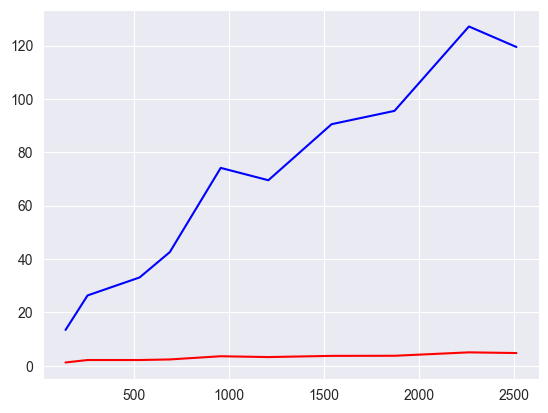

In [12]:
# calculate avg time to convergence
avgs_seq_borg = {}
avgs_pydsol = {}

def avg_time_to_95(df, dict):
    for num_nodes in df['number_of_nodes'].unique():
        subset = df.query(f" number_of_nodes == {num_nodes}")
        print(subset)
        avg = np.median(subset['time_of_95'])
        dict[num_nodes] = avg

avg_time_to_95(time_of_95_seq_borg, avgs_seq_borg)
avg_time_to_95(time_of_95_pydsol_borg, avgs_pydsol)

plt.plot(*zip(*sorted(avgs_seq_borg.items())), color='red')
plt.plot(*zip(*sorted(avgs_pydsol.items())), color='blue')

C:\Users\isvandroffelaa\Documents\model\simopt\analysis\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\isvandroffelaa\Documents\model\simopt\analysis\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\isvandroffelaa\Documents\model\simopt\analysis\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\isvandroffelaa\Documents\model\simopt\analysis\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_c

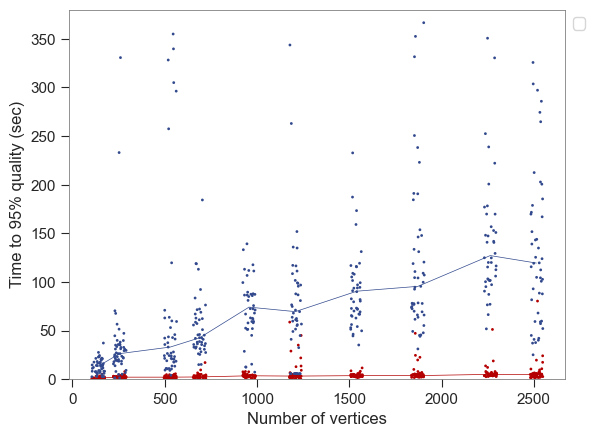

In [16]:
sns.set_style('ticks')

plt.plot(*zip(*sorted(avgs_seq_borg.items())), color='#b40000', linewidth=0.5)
plt.plot(*zip(*sorted(avgs_pydsol.items())), color='#32498d', linewidth=0.5)

ax = sns.stripplot(data=combined_results_95, x='number_of_nodes', y='time_of_95', hue="algorithm", palette=hue_dict, size=2, native_scale=True, jitter=0.3, legend=False)
ax.set(xlabel='Number of vertices', ylabel='Time to 95% quality (sec)')
# ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 7.5], list(combined_results_95['number_of_nodes'].unique()))
# ax.get_xticks()
ax.set_ylim([0, 380])

sns.set_context("paper")
sns.set_theme(style='white')
for _,s in ax.spines.items():
    s.set_linewidth(0.6)
    s.set_color('grey')
ax.tick_params(width=0.8)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='upper left')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig('figs/Rotterdam_stripplot_nodes_legendFalse.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
combined_results_95

,number_of_nodes,algorithm,time_of_95,nfe_of_95,config,seed,pi_0,pi_1,pi_2,pi_3,pi_4,probability_SBX,probability_PCX,probability_DE,probability_UNDX,probability_SPX,probability_UM,number_of_units,elapsed time (min)
0,140,"sequential simulation-optimization, metaheuristic",0.826881,533.0,0,0,17.0,15.0,2.0,13.0,34.0,0.342857,0.266667,0.142857,0.123810,0.019048,0.104762,5.0,0.013781
1,140,"sequential simulation-optimization, metaheuristic",1.002710,827.0,2,0,2.0,1.0,13.0,41.0,47.0,0.424528,0.358491,0.075472,0.066038,0.009434,0.066038,5.0,0.016712
2,140,"sequential simulation-optimization, metaheuristic",1.425807,1568.0,3,0,13.0,0.0,15.0,5.0,26.0,0.792453,0.103774,0.028302,0.009434,0.009434,0.056604,5.0,0.023763
3,140,"sequential simulation-optimization, metaheuristic",0.762000,671.0,4,0,15.0,42.0,4.0,13.0,3.0,0.421569,0.245098,0.088235,0.078431,0.009804,0.156863,5.0,0.012700
4,140,"sequential simulation-optimization, metaheuristic",0.231478,100.0,5,0,0.0,3.0,0.0,0.0,1.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,5.0,0.003858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,2514,"simulation model optimization, metaheuristic",104.261863,3356.0,4,4,195.0,15.0,413.0,55.0,54.0,0.952830,0.009434,0.009434,0.009434,0.009434,0.009434,5.0,1.737698
469,2514,"simulation model optimization, metaheuristic",169.773963,5693.0,5,4,14.0,313.0,43.0,19.0,326.0,0.896226,0.009434,0.009434,0.009434,0.009434,0.066038,5.0,2.829566
470,2514,"simulation model optimization, metaheuristic",45.046245,1285.0,6,4,5.0,111.0,129.0,23.0,14.0,0.688679,0.169811,0.103774,0.009434,0.009434,0.018868,5.0,0.750771
471,2514,"simulation model optimization, metaheuristic",115.632824,4105.0,7,4,30.0,11.0,69.0,29.0,114.0,0.943396,0.009434,0.009434,0.009434,0.009434,0.018868,5.0,1.927214


C:\Users\isvandroffelaa\Documents\model\simopt\analysis\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\isvandroffelaa\Documents\model\simopt\analysis\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\isvandroffelaa\Documents\model\simopt\analysis\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\isvandroffelaa\Documents\model\simopt\analysis\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_c

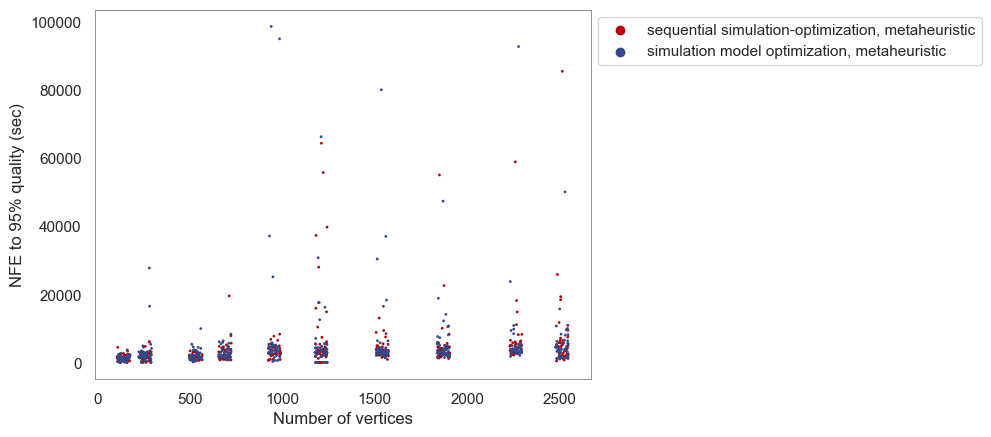

In [15]:
ax = sns.stripplot(data=combined_results_95, x='number_of_nodes', y='nfe_of_95', hue="algorithm", palette=hue_dict, size=2, native_scale=True, jitter=0.3)
ax.set(xlabel='Number of vertices', ylabel='NFE to 95% quality (sec)')
# ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 7.5], list(combined_results_95['number_of_nodes'].unique()))
# ax.get_xticks()
# ax.set_ylim([0, 175])

sns.set_context("paper")
sns.set_theme(style='ticks')
for _,s in ax.spines.items():
    s.set_linewidth(0.6)
    s.set_color('grey')
ax.tick_params(width=0.8)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='upper left')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig('figs/Rotterdam_stripplot_nodes_nfe.png', dpi=300, bbox_inches='tight')
plt.show()